<a href="https://colab.research.google.com/github/Sarvani-5/KneeOA_DL/blob/main/EfficientNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import kagglehub
from google.colab import drive
import shutil
import os

# Mount Google Drive
drive.mount('/content/drive')

# Download the dataset from Kaggle
path = kagglehub.dataset_download("tommyngx/digital-knee-xray")
print("Path to dataset files:", path)

# Define destination path in Google Drive
drive_path = '/content/drive/MyDrive/KneeOA'  # Change this to your preferred path

# Copy the dataset to Google Drive
if os.path.exists(drive_path):
    shutil.rmtree(drive_path)  # Remove if already exists
shutil.copytree(path, drive_path)

print(f"Dataset successfully saved to Google Drive at: {drive_path}")

Mounted at /content/drive
Path to dataset files: /kaggle/input/digital-knee-xray
Dataset successfully saved to Google Drive at: /content/drive/MyDrive/KneeOA


In [ ]:
from google.colab import drive
# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Dropout, Flatten, Dense, Input, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input

# Define class mapping
knee_classes = {'0Normal': 0, '1Doubtful': 1, '2Mild': 2, '3Moderate': 3, '4Severe': 4}
class_names = list(knee_classes.keys())

# Enhanced data loader that combines both datasets
def load_combined_data(exp1_path, exp2_path, image_size=200):
    X, y = [], []

    # Load MedicalExpert-I
    print("Loading MedicalExpert-I...")
    for class_name, class_idx in knee_classes.items():
        class_path = os.path.join(exp1_path, class_name)
        if not os.path.exists(class_path):
            print(f"Warning: Missing directory {class_path}")
            continue

        print(f"Processing {class_name}...", end=' ')
        count = 0
        for img_name in os.listdir(class_path):
            try:
                img_path = os.path.join(class_path, img_name)
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                if img is None:
                    continue

                img = cv2.resize(img, (image_size, image_size))
                # Convert grayscale to RGB by repeating the channel
                img_rgb = cv2.merge([img, img, img])
                X.append(img_rgb)
                y.append(class_idx)
                count += 1
            except Exception as e:
                print(f"Error processing {img_path}: {str(e)}")
        print(f"Loaded {count} samples")

    # Load MedicalExpert-II
    print("\nLoading MedicalExpert-II...")
    for class_name, class_idx in knee_classes.items():
        class_path = os.path.join(exp2_path, class_name)
        if not os.path.exists(class_path):
            print(f"Warning: Missing directory {class_path}")
            continue

        print(f"Processing {class_name}...", end=' ')
        count = 0
        for img_name in os.listdir(class_path):
            try:
                img_path = os.path.join(class_path, img_name)
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                if img is None:
                    continue

                img = cv2.resize(img, (image_size, image_size))
                # Convert grayscale to RGB by repeating the channel
                img_rgb = cv2.merge([img, img, img])
                X.append(img_rgb)
                y.append(class_idx)
                count += 1
            except Exception as e:
                print(f"Error processing {img_path}: {str(e)}")
        print(f"Loaded {count} samples")

    return np.array(X), np.array(y)

# Paths to your datasets - UPDATE THESE
medical_expert_I_path = "/content/drive/MyDrive/KneeOA/MedicalExpert-I"
medical_expert_II_path = "/content/drive/MyDrive/KneeOA/MedicalExpert-II"

# Load combined data
X, y = load_combined_data(medical_expert_I_path, medical_expert_II_path)

# Check class distribution
print("\nClass distribution in combined dataset:")
for class_name, class_idx in knee_classes.items():
    print(f"{class_name}: {np.sum(y == class_idx)} samples")

# Convert to float32 and preprocess for InceptionResNetV2
X = X.astype('float32')
X = preprocess_input(X)  # Preprocess for InceptionResNetV2
y = to_categorical(y, num_classes=5)

# Split into train and test sets (now combining both datasets)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

print(f"\nTraining samples: {len(X_train)}")
print(f"Test samples: {len(X_test)}")

# Data augmentation for training set
train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='constant',
    cval=0
)

# Build model using InceptionResNetV2
def build_inception_resnet():
    base_model = InceptionResNetV2(
        include_top=False,
        weights='imagenet',
        input_shape=(200, 200, 3),
        pooling=None
    )

    # Freeze the base model layers first
    base_model.trainable = False

    inputs = Input(shape=(200, 200, 3))
    x = base_model(inputs, training=False)
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    outputs = Dense(5, activation='softmax')(x)

    model = Model(inputs, outputs)

    optimizer = Adam(learning_rate=0.0001)
    model.compile(optimizer=optimizer,
                loss='categorical_crossentropy',
                metrics=['accuracy'])
    return model, base_model

model, base_model = build_inception_resnet()
model.summary()

# Callbacks
callbacks = [
    EarlyStopping(patience=15, restore_best_weights=True, monitor='val_accuracy'),
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=1e-6),
    ModelCheckpoint('/content/drive/MyDrive/KneeOA/best_model.keras',
                   monitor='val_accuracy',
                   save_best_only=True,
                   mode='max')
]

# First train with frozen layers
print("\nTraining top layers...")
history = model.fit(
    train_datagen.flow(X_train, y_train, batch_size=32),
    epochs=30,
    validation_data=(X_test, y_test),
    callbacks=callbacks
)

# Unfreeze some layers for fine-tuning
base_model.trainable = True
for layer in base_model.layers[:len(base_model.layers)//2]:
    layer.trainable = False

model.compile(optimizer=Adam(learning_rate=1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

print("\nFine-tuning model...")
history_fine = model.fit(
    train_datagen.flow(X_train, y_train, batch_size=32),
    epochs=100,
    initial_epoch=history.epoch[-1],
    validation_data=(X_test, y_test),
    callbacks=callbacks
)

# Combine histories
combined_history = {}
for key in history.history:
    combined_history[key] = history.history[key] + history_fine.history[key]

# Evaluate model
y_pred = np.argmax(model.predict(X_test), axis=1)
y_true = np.argmax(y_test, axis=1)

print("\nConfusion Matrix:")
print(confusion_matrix(y_true, y_pred))
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix as heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(combined_history['accuracy'], label='Train Accuracy')
plt.plot(combined_history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(combined_history['loss'], label='Train Loss')
plt.plot(combined_history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.legend()
plt.show()

# Save final model in .keras format
model.save('/content/drive/MyDrive/KneeOA/knee_oa_inception_resnet.keras')
print("Model saved as knee_oa_inception_resnet.keras")

# Sample predictions
def predict_sample_images(model, X_test, y_test, num_samples=5):
    sample_indices = np.random.choice(len(X_test), num_samples, replace=False)

    plt.figure(figsize=(15, 5))
    for i, idx in enumerate(sample_indices, 1):
        image = X_test[idx]
        true_class = np.argmax(y_test[idx])

        # Make prediction
        pred_probs = model.predict(np.expand_dims(image, axis=0))
        pred_class = np.argmax(pred_probs)

        # Convert image back for display
        image = (image - image.min()) / (image.max() - image.min())  # Normalize to 0-1

        plt.subplot(1, num_samples, i)
        plt.imshow(image)
        plt.title(f"True: {class_names[true_class]}\nPred: {class_names[pred_class]}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Display sample predictions
print("\nSample predictions on test set:")
predict_sample_images(model, X_test, y_test, num_samples=5)

Loading MedicalExpert-I...
Processing 0Normal... Loaded 514 samples
Processing 1Doubtful... Loaded 477 samples
Processing 2Mild... Loaded 232 samples
Processing 3Moderate... Loaded 221 samples
Processing 4Severe... Loaded 206 samples

Loading MedicalExpert-II...
Processing 0Normal... Loaded 504 samples
Processing 1Doubtful... Loaded 488 samples
Processing 2Mild... Loaded 232 samples
Processing 3Moderate... Loaded 221 samples
Processing 4Severe... Loaded 206 samples

Class distribution in combined dataset:
0Normal: 1018 samples
1Doubtful: 965 samples
2Mild: 464 samples
3Moderate: 442 samples
4Severe: 412 samples

Training samples: 2640
Test samples: 661
219055592/219055592 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 200, 200, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ inception_resnet_v2             │ (None, 4, 4, 1536)     │    54,336,736 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1536)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       393,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_203         │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │         1,285 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 54,732,517 (208.79 MB)

 Trainable params: 395,269 (1.51 MB)

 Non-trainable params: 54,337,248 (207.28 MB)


Training top layers...


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
20/83 ━━━━━━━━━━━━━━━━━━━━ 16s 256ms/step - accuracy: 0.2217 - loss: 2.5644

Attempting to load model from /content/drive/MyDrive/KneeOA/knee_oa_inception_resnet.h5 with CustomScaleLayer


Model loaded successfully!

Processing 0Normal images:
  NormalG0 (334).png - Predicted: 0Normal - Confidence: 29.95%
  NormalG0 (309).png - Predicted: 0Normal - Confidence: 29.95%
  NormalG0 (256).png - Predicted: 0Normal - Confidence: 29.95%
  NormalG0 (211).png - Predicted: 0Normal - Confidence: 29.95%
  NormalG0 (317).png - Predicted: 0Normal - Confidence: 29.95%

Processing 1Doubtful images:
  DoubtfulG1 (266).png - Predicted: 0Normal - Confidence: 29.95%
  DoubtfulG1 (431).png - Predicted: 0Normal - Confidence: 29.95%
  DoubtfulG1 (397).png - Predicted: 0Normal - Confidence: 29.95%
  DoubtfulG1 (18).png - Predicted: 0Normal - Confidence: 29.95%
  DoubtfulG1 (54).png - Predicted: 0Normal - Confidence: 29.95%

Processing 2Mild images:
  MildG2 (213).png - Predicted: 0Normal - Confidence: 29.95%
  MildG2 (174).png - Predicted: 0Normal - Confidence: 29.95%
  MildG2 (109).png - Predicted: 0Normal - Confidence: 29.95%
  MildG2 (61).png - Predicted: 0Normal - Confidence: 29.95%
  MildG2

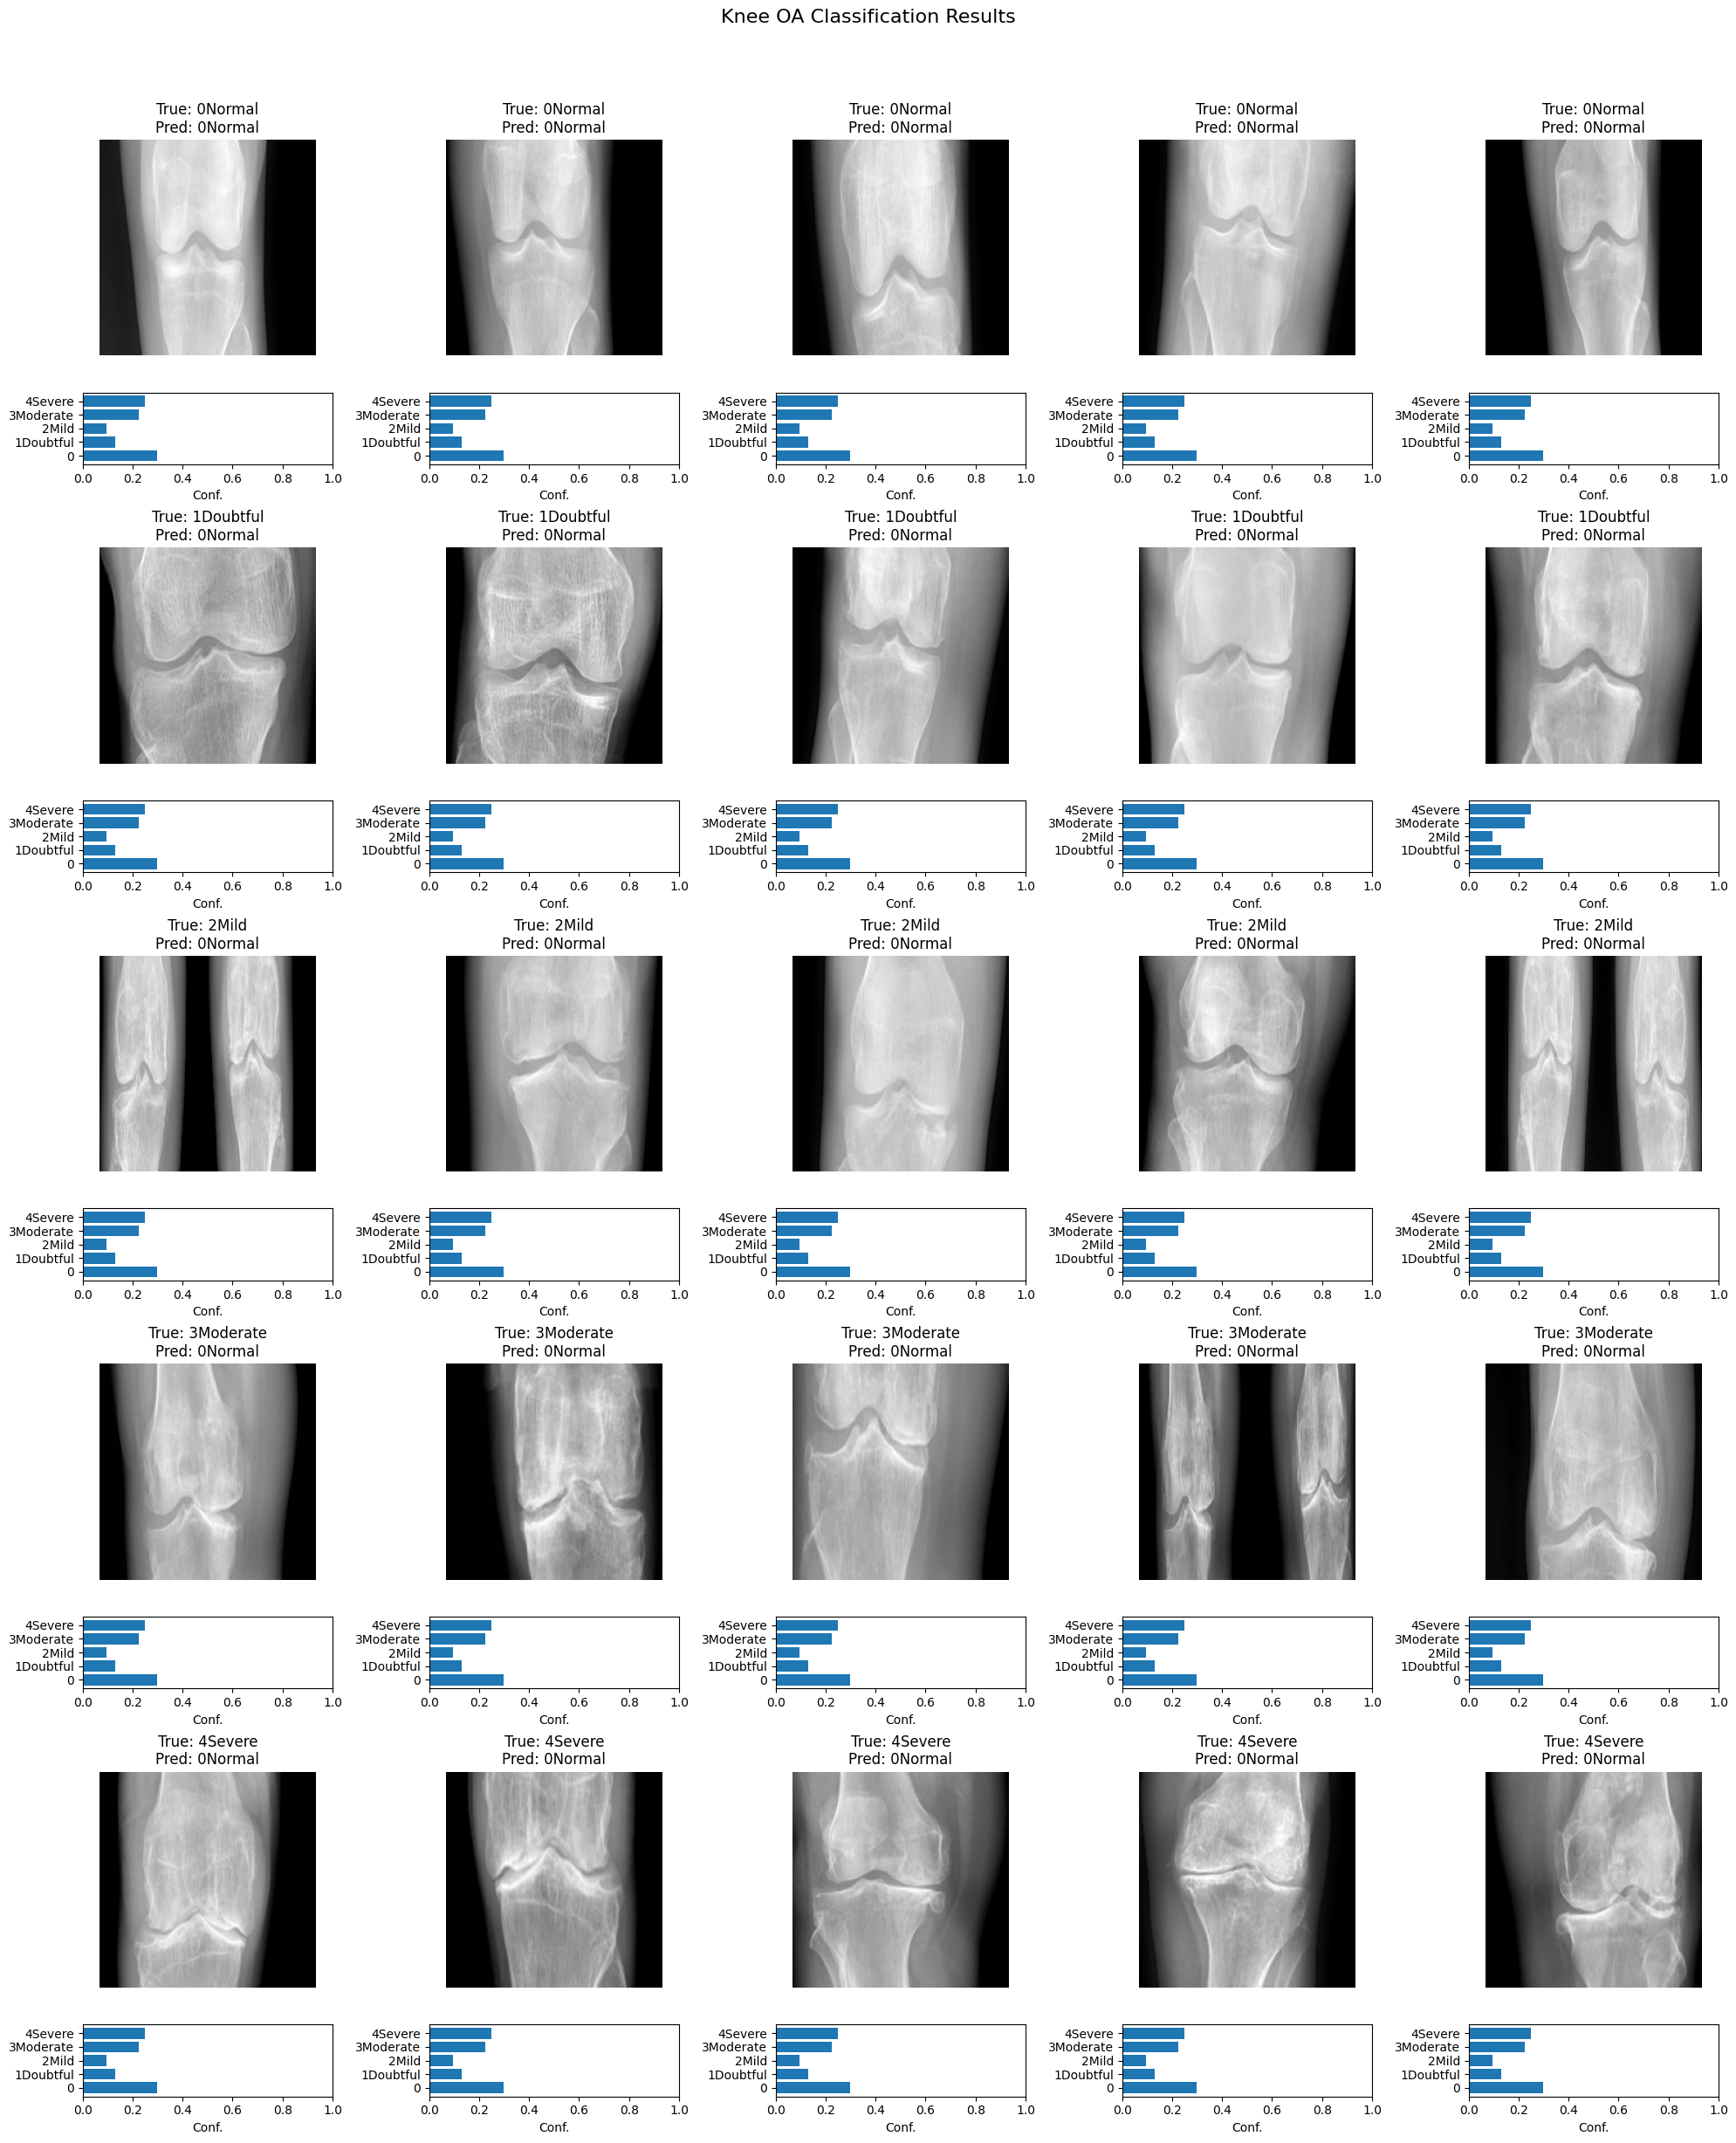

In [ ]:
import os
import numpy as np
import cv2
import tensorflow as tf
import random
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.applications.inception_resnet_v2 import preprocess_input
from matplotlib.gridspec import GridSpec

# Define class mapping (must match your training)
knee_classes = {'0Normal': 0, '1Doubtful': 1, '2Mild': 2, '3Moderate': 3, '4Severe': 4}
class_names = list(knee_classes.keys())

# Define the CustomScaleLayer properly to handle multiple inputs
class CustomScaleLayer(tf.keras.layers.Layer):
    def __init__(self, scale=0.17, **kwargs):
        super(CustomScaleLayer, self).__init__(**kwargs)
        self.scale = scale

    def call(self, inputs):
        # Handle the case when inputs is a list of tensors
        if isinstance(inputs, list):
            # For list input, we'll combine the tensors first
            combined = tf.add_n(inputs)  # Sum all tensors
            return combined * self.scale
        else:
            # For single tensor input
            return inputs * self.scale

    def compute_output_shape(self, input_shape):
        # If input is a list, return shape of first item
        if isinstance(input_shape, list):
            return input_shape[0]
        return input_shape

    def get_config(self):
        config = super(CustomScaleLayer, self).get_config()
        config.update({"scale": self.scale})
        return config

# Another approach: try a different CustomScaleLayer implementation
class CustomScaleLayer2(tf.keras.layers.Layer):
    def __init__(self, scale=0.17, **kwargs):
        super(CustomScaleLayer2, self).__init__(**kwargs)
        self.scale = scale

    def call(self, inputs):
        # Just pass through the inputs without scaling
        if isinstance(inputs, list):
            return inputs[0]  # Return first tensor from list
        return inputs

    def get_config(self):
        config = super(CustomScaleLayer2, self).get_config()
        config.update({"scale": self.scale})
        return config

# Function to load and preprocess new images
def preprocess_image(image_path, img_size=200):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise ValueError(f"Could not read image at {image_path}")

    # Resize the image
    img = cv2.resize(img, (img_size, img_size))

    # Convert grayscale to RGB by repeating the channel
    img_rgb = cv2.merge([img, img, img])

    # Convert to float32 and apply InceptionResNetV2 preprocessing
    img_rgb = img_rgb.astype('float32')
    img_rgb = preprocess_input(img_rgb)

    # Add batch dimension
    return np.expand_dims(img_rgb, axis=0), img

# Load the model with proper error handling
def load_knee_model(model_path):
    # Try multiple CustomLayer implementations
    custom_objects = {
        'CustomScaleLayer': CustomScaleLayer,
        'CustomScaleLayer2': CustomScaleLayer2
    }

    # Try first implementation
    try:
        print(f"Attempting to load model from {model_path} with CustomScaleLayer")
        model = load_model(model_path, custom_objects={'CustomScaleLayer': CustomScaleLayer})
        print("Model loaded successfully!")
        return model
    except Exception as e:
        print(f"Error with first implementation: {str(e)}")

        # Try second implementation
        try:
            print(f"Trying alternate implementation...")
            model = load_model(model_path, custom_objects={'CustomScaleLayer': CustomScaleLayer2})
            print("Model loaded with alternate implementation!")
            return model
        except Exception as e:
            print(f"Error with alternate implementation: {str(e)}")

            # If both implementations fail, try rebuilding and loading just the weights
            print("Both implementations failed. Let's try another approach")
            try:
                # Recreate the model architecture
                from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2
                from tensorflow.keras.models import Model
                from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input, BatchNormalization, Dropout

                print("Rebuilding model architecture...")
                base_model = InceptionResNetV2(
                    include_top=False,
                    weights='imagenet',
                    input_shape=(200, 200, 3),
                    pooling=None
                )

                inputs = Input(shape=(200, 200, 3))
                x = base_model(inputs, training=False)
                x = GlobalAveragePooling2D()(x)
                x = Dense(256, activation='relu')(x)
                x = BatchNormalization()(x)
                x = Dropout(0.5)(x)
                outputs = Dense(5, activation='softmax')(x)

                new_model = Model(inputs, outputs)

                # Try to load weights
                print("Attempting to load weights...")
                new_model.load_weights(model_path, by_name=True)
                print("Weights loaded successfully!")
                return new_model

            except Exception as e:
                print(f"Error rebuilding model: {str(e)}")
                print("All approaches failed. Please consider retraining your model.")
                raise

# Function to predict knee OA grade from an image
def predict_knee_oa(model, image_path):
    try:
        # Preprocess the image
        processed_img, original_img = preprocess_image(image_path)

        # Make prediction
        preds = model.predict(processed_img, verbose=0)
        class_idx = np.argmax(preds[0])
        confidence = preds[0][class_idx]

        # Return class name, confidence, all confidences, and original image
        return class_names[class_idx], confidence, preds[0], original_img
    except Exception as e:
        print(f"Prediction error for {image_path}: {str(e)}")
        return None, None, None, None

# Function to get random images from each class folder
def get_random_images_per_class(dataset_path, num_per_class=5):
    selected_images = {}

    for class_name in knee_classes.keys():
        class_path = os.path.join(dataset_path, class_name)
        if not os.path.exists(class_path):
            print(f"Warning: Directory {class_path} not found")
            continue

        # Get all image files in the directory
        image_files = [f for f in os.listdir(class_path)
                      if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tif', '.tiff'))]

        if len(image_files) == 0:
            print(f"Warning: No images found in {class_path}")
            continue

        # Select random samples (or all if less than requested)
        sample_count = min(num_per_class, len(image_files))
        selected = random.sample(image_files, sample_count)

        # Store the full paths of selected images
        selected_images[class_name] = [os.path.join(class_path, img) for img in selected]

    return selected_images

# Function to visualize multiple predictions in a grid
def visualize_predictions(predictions, title="Knee OA Classification Results"):
    num_images = len(predictions)
    if num_images == 0:
        print("No predictions to visualize")
        return

    # Calculate grid dimensions
    cols = min(5, num_images)
    rows = (num_images + cols - 1) // cols

    plt.figure(figsize=(cols * 4, rows * 5))
    gs = GridSpec(rows, cols)

    for i, pred_data in enumerate(predictions):
        row = i // cols
        col = i % cols

        # Create subplot with 2 rows for each prediction
        inner_gs = gs[row, col].subgridspec(2, 1, height_ratios=[3, 1])

        # Image and prediction
        ax1 = plt.subplot(inner_gs[0])
        ax1.imshow(pred_data["image"], cmap='gray')
        ax1.set_title(f"True: {pred_data['true_class']}\nPred: {pred_data['predicted_class']}")
        ax1.axis('off')

        # Confidence bars
        ax2 = plt.subplot(inner_gs[1])
        y_pos = np.arange(len(class_names))
        ax2.barh(y_pos, pred_data["confidences"], align='center')
        ax2.set_yticks(y_pos)
        ax2.set_yticklabels([name.split('N')[0] for name in class_names])
        ax2.set_xlabel('Conf.')
        ax2.set_xlim(0, 1)

    plt.tight_layout()
    plt.suptitle(title, fontsize=16)
    plt.subplots_adjust(top=0.92)
    plt.show()

# Main execution
if __name__ == "__main__":
    # Path to your saved model
    model_path = '/content/drive/MyDrive/KneeOA/knee_oa_inception_resnet.h5'

    # Path to MedicalExpert-II dataset
    medical_expert_II_path = "/content/drive/MyDrive/KneeOA/MedicalExpert-II"

    # Number of random images to select per class
    samples_per_class = 5

    # Load model
    model = load_knee_model(model_path)

    # Get random images from each class
    selected_images = get_random_images_per_class(medical_expert_II_path, samples_per_class)

    # Store all predictions for visualization
    all_predictions = []

    # Process each class
    for class_name, image_paths in selected_images.items():
        print(f"\nProcessing {class_name} images:")

        for img_path in image_paths:
            img_name = os.path.basename(img_path)
            predicted_class, confidence, all_confidences, original_img = predict_knee_oa(model, img_path)

            if predicted_class is not None:
                print(f"  {img_name} - Predicted: {predicted_class} - Confidence: {confidence:.2%}")

                # Store prediction data
                all_predictions.append({
                    "image": original_img,
                    "true_class": class_name,
                    "predicted_class": predicted_class,
                    "confidence": confidence,
                    "confidences": all_confidences,
                    "correct": class_name == predicted_class
                })
            else:
                print(f"  Failed to process {img_name}")

    # Calculate accuracy
    if all_predictions:
        correct_predictions = sum(1 for p in all_predictions if p["correct"])
        accuracy = correct_predictions / len(all_predictions)
        print(f"\nOverall accuracy on random samples: {accuracy:.2%}")

        # Count by class
        class_counts = {class_name: {"total": 0, "correct": 0} for class_name in knee_classes.keys()}
        for p in all_predictions:
            true_class = p["true_class"]
            class_counts[true_class]["total"] += 1
            if p["correct"]:
                class_counts[true_class]["correct"] += 1

        print("\nAccuracy breakdown by class:")
        for class_name, counts in class_counts.items():
            if counts["total"] > 0:
                class_accuracy = counts["correct"] / counts["total"]
                print(f"  {class_name}: {class_accuracy:.2%} ({counts['correct']}/{counts['total']})")

        # Visualize all predictions
        visualize_predictions(all_predictions)
    else:
        print("No predictions were made. Please check your dataset paths and model.")

24274472/24274472 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Initial Training Phase


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 78s 580ms/step - accuracy: 0.2911 - loss: 0.4142 - val_accuracy: 0.3419 - val_loss: 0.1784 - learning_rate: 1.0000e-04
Epoch 2/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 41s 272ms/step - accuracy: 0.3837 - loss: 0.2951 - val_accuracy: 0.5204 - val_loss: 0.1411 - learning_rate: 1.0000e-04
Epoch 3/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 25s 302ms/step - accuracy: 0.4454 - loss: 0.2586 - val_accuracy: 0.5613 - val_loss: 0.1197 - learning_rate: 1.0000e-04
Epoch 4/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 25s 302ms/step - accuracy: 0.4543 - loss: 0.2383 - val_accuracy: 0.6097 - val_loss: 0.1082 - learning_rate: 1.0000e-04
Epoch 5/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 23s 278ms/step - accuracy: 0.4638 - loss: 0.2449 - val_accuracy: 0.5779 - val_loss: 0.1077 - learning_rate: 1.0000e-04
Epoch 6/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 42s 288ms/step - accuracy: 0.5001 - loss: 0.2161 - val_accuracy: 0.5976 - val_loss: 0.1144 - learning_rate: 1.0000e-04
Epoch 7/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 23s 282ms/ste

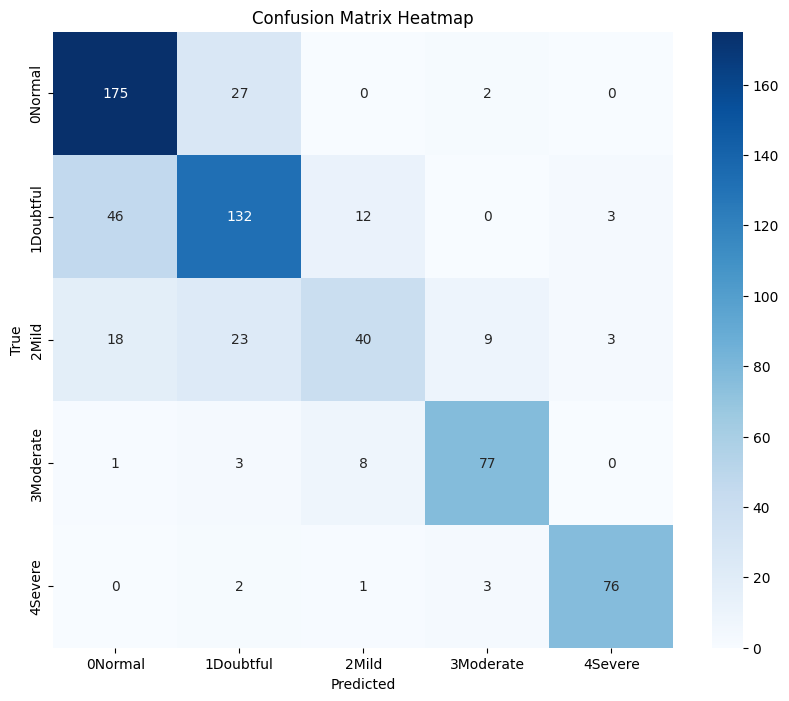

              precision    recall  f1-score   support

     0Normal       0.73      0.86      0.79       204
   1Doubtful       0.71      0.68      0.69       193
       2Mild       0.66      0.43      0.52        93
   3Moderate       0.85      0.87      0.86        89
     4Severe       0.93      0.93      0.93        82

    accuracy                           0.76       661
   macro avg       0.77      0.75      0.76       661
weighted avg       0.75      0.76      0.75       661



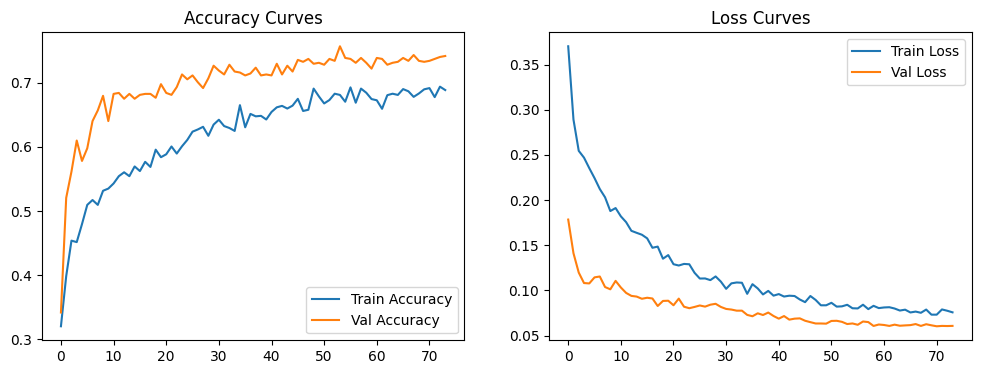

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


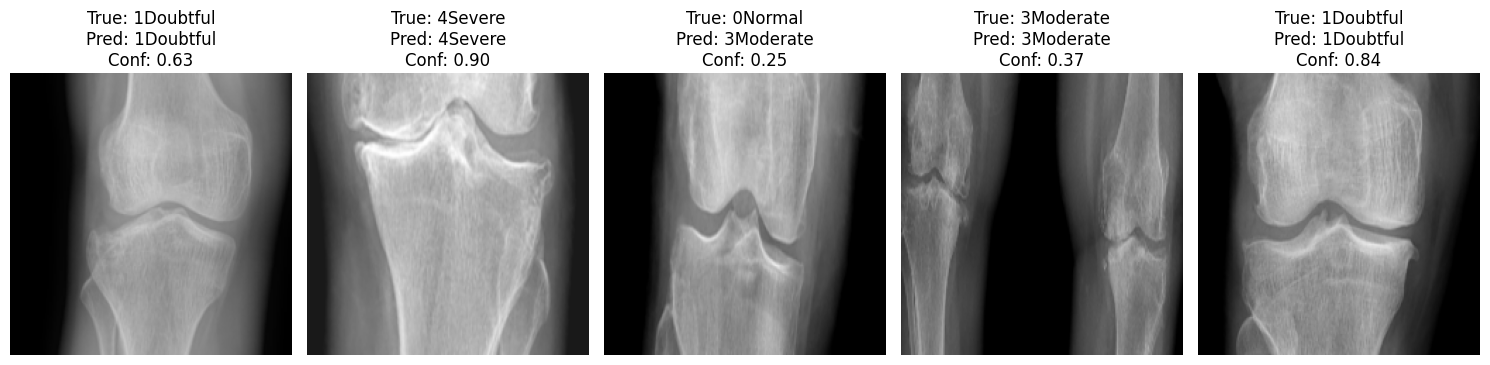

Model saved successfully!


In [ ]:
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, BatchNormalization, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.applications.efficientnet_v2 import EfficientNetV2B0, preprocess_input
from tensorflow.keras.losses import CategoricalFocalCrossentropy

# 1. Initialize and Load Data
knee_classes = {'0Normal': 0, '1Doubtful': 1, '2Mild': 2, '3Moderate': 3, '4Severe': 4}
class_names = list(knee_classes.keys())

def load_data(path, image_size=200):
    X, y = [], []
    for class_name, class_idx in knee_classes.items():
        class_path = os.path.join(path, class_name)
        for img_name in os.listdir(class_path):
            img_path = os.path.join(class_path, img_name)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if img is not None:
                img = cv2.resize(img, (image_size, image_size))
                img_rgb = cv2.merge([img, img, img])  # Convert to 3-channel
                X.append(img_rgb)
                y.append(class_idx)
    return np.array(X), np.array(y)

# Load datasets
medical_expert_I_path = "/content/drive/MyDrive/KneeOA/MedicalExpert-I"
medical_expert_II_path = "/content/drive/MyDrive/KneeOA/MedicalExpert-II"

X1, y1 = load_data(medical_expert_I_path)
X2, y2 = load_data(medical_expert_II_path)
X = np.concatenate((X1, X2))
y = np.concatenate((y1, y2))

# 2. Preprocessing
X = preprocess_input(X.astype('float32'))
y = to_categorical(y, num_classes=5)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# 3. Data Augmentation
train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='constant',
    cval=0
)

# 4. Model Building
def build_model():
    base_model = EfficientNetV2B0(
        include_top=False,
        weights='imagenet',
        input_shape=(200, 200, 3),
        pooling=None
    )
    base_model.trainable = False

    inputs = Input(shape=(200, 200, 3))
    x = base_model(inputs)
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='swish')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.6)(x)
    outputs = Dense(5, activation='softmax')(x)

    model = Model(inputs, outputs)

    # Focal loss parameters
    loss = CategoricalFocalCrossentropy(alpha=[0.2, 0.2, 0.2, 0.2, 0.2], gamma=2)

    model.compile(
        optimizer=Adam(learning_rate=1e-4),
        loss=loss,
        metrics=['accuracy']
    )
    return model, base_model

# 5. Class Weight Calculation
class_weights = compute_class_weight(
    'balanced',
    classes=np.unique(np.argmax(y_train, axis=1)),
    y=np.argmax(y_train, axis=1)
)
class_weights = dict(enumerate(class_weights))

# 6. Training Setup
callbacks = [
    EarlyStopping(patience=20, monitor='val_accuracy', restore_best_weights=True),
    ReduceLROnPlateau(factor=0.5, patience=5, min_lr=1e-7),
    ModelCheckpoint('best_model_efficient.keras', monitor='val_accuracy', save_best_only=True)
]

model, base_model = build_model()

# 7. Initial Training
print("Initial Training Phase")
history = model.fit(
    train_datagen.flow(X_train, y_train, batch_size=32),
    epochs=100,
    validation_data=(X_test, y_test),
    callbacks=callbacks,
    class_weight=class_weights
)

# 8. Fine-tuning
print("\nFine-tuning Phase")
base_model.trainable = True
for layer in base_model.layers[:150]:
    layer.trainable = False

model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss=CategoricalFocalCrossentropy(),
    metrics=['accuracy']
)

history_fine = model.fit(
    train_datagen.flow(X_train, y_train, batch_size=32),
    epochs=50,
    initial_epoch=history.epoch[-1],
    validation_data=(X_test, y_test),
    callbacks=callbacks
)

# 9. Evaluation
def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10,8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names,
                yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix Heatmap')
    plt.show()

y_pred = np.argmax(model.predict(X_test), axis=1)
y_true = np.argmax(y_test, axis=1)

plot_confusion_matrix(y_true, y_pred)
print(classification_report(y_true, y_pred, target_names=class_names))

# 10. Visualization
def plot_training_history(history):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title('Accuracy Curves')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Loss Curves')
    plt.legend()
    plt.show()

plot_training_history(history)

# 11. Sample Predictions
def visualize_predictions(samples=5):
    indices = np.random.choice(len(X_test), samples)
    plt.figure(figsize=(15, 5))
    for i, idx in enumerate(indices):
        img = X_test[idx]
        pred = model.predict(np.expand_dims(img, axis=0))[0]

        plt.subplot(1, samples, i+1)
        plt.imshow(cv2.cvtColor(img.astype('uint8'), cv2.COLOR_BGR2RGB))
        plt.title(f"True: {class_names[y_true[idx]]}\nPred: {class_names[np.argmax(pred)]}\nConf: {max(pred):.2f}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

visualize_predictions()

# 12. Save Final Model
model.save('knee_oa_efficientnet_final.keras')
print("Model saved successfully!")

Initial Training Phase


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/60
83/83 ━━━━━━━━━━━━━━━━━━━━ 69s 530ms/step - accuracy: 0.2627 - loss: 0.4247 - val_accuracy: 0.3979 - val_loss: 0.1637 - learning_rate: 1.0000e-04
Epoch 2/60
83/83 ━━━━━━━━━━━━━━━━━━━━ 24s 286ms/step - accuracy: 0.3997 - loss: 0.2924 - val_accuracy: 0.4236 - val_loss: 0.1406 - learning_rate: 1.0000e-04
Epoch 3/60
83/83 ━━━━━━━━━━━━━━━━━━━━ 24s 294ms/step - accuracy: 0.4329 - loss: 0.2769 - val_accuracy: 0.5113 - val_loss: 0.1181 - learning_rate: 1.0000e-04
Epoch 4/60
83/83 ━━━━━━━━━━━━━━━━━━━━ 23s 279ms/step - accuracy: 0.4436 - loss: 0.2572 - val_accuracy: 0.6157 - val_loss: 0.1045 - learning_rate: 1.0000e-04
Epoch 5/60
83/83 ━━━━━━━━━━━━━━━━━━━━ 24s 282ms/step - accuracy: 0.4633 - loss: 0.2422 - val_accuracy: 0.5825 - val_loss: 0.1132 - learning_rate: 1.0000e-04
Epoch 6/60
83/83 ━━━━━━━━━━━━━━━━━━━━ 24s 286ms/step - accuracy: 0.5082 - loss: 0.2191 - val_accuracy: 0.6369 - val_loss: 0.1112 - learning_rate: 1.0000e-04
Epoch 7/60
83/83 ━━━━━━━━━━━━━━━━━━━━ 24s 291ms/step - acc

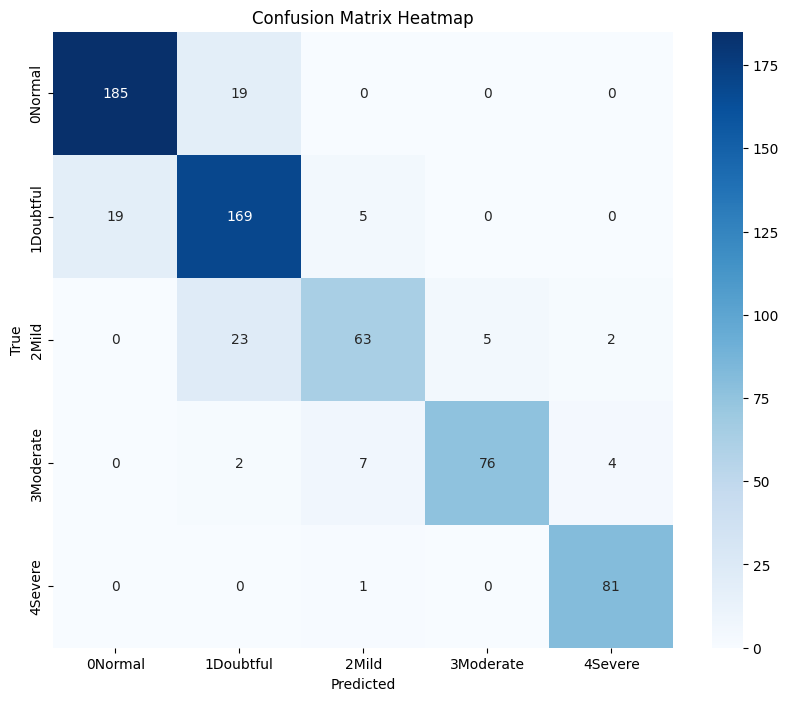

              precision    recall  f1-score   support

     0Normal       0.91      0.91      0.91       204
   1Doubtful       0.79      0.88      0.83       193
       2Mild       0.83      0.68      0.75        93
   3Moderate       0.94      0.85      0.89        89
     4Severe       0.93      0.99      0.96        82

    accuracy                           0.87       661
   macro avg       0.88      0.86      0.87       661
weighted avg       0.87      0.87      0.87       661



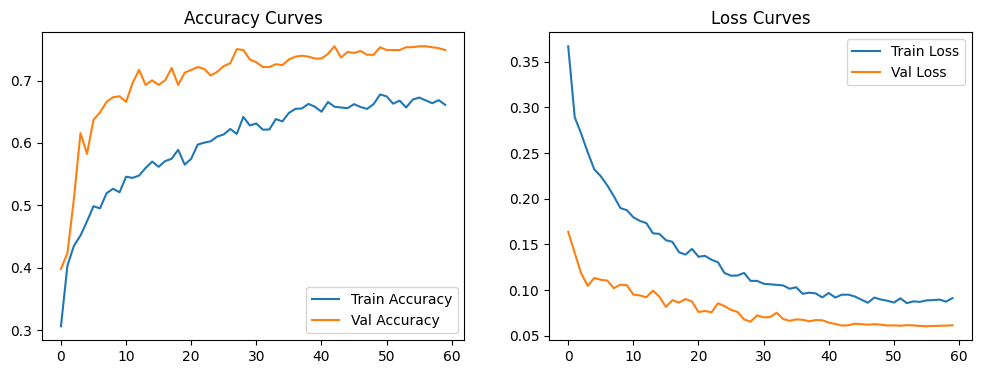

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


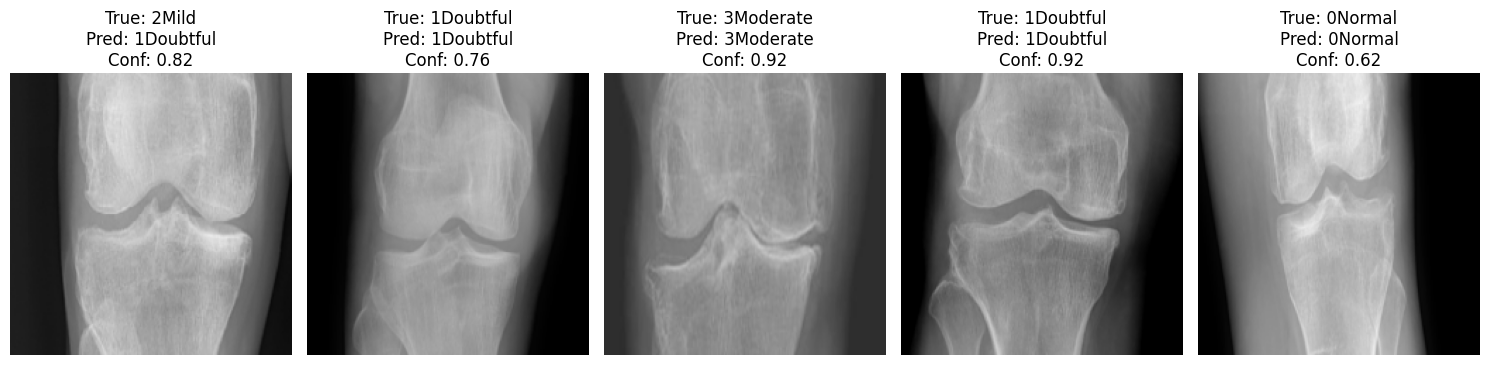

Model saved successfully!


In [ ]:
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, BatchNormalization, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.applications.efficientnet_v2 import EfficientNetV2B0, preprocess_input
from tensorflow.keras.losses import CategoricalFocalCrossentropy

# 1. Initialize and Load Data
knee_classes = {'0Normal': 0, '1Doubtful': 1, '2Mild': 2, '3Moderate': 3, '4Severe': 4}
class_names = list(knee_classes.keys())

def load_data(path, image_size=200):
    X, y = [], []
    for class_name, class_idx in knee_classes.items():
        class_path = os.path.join(path, class_name)
        for img_name in os.listdir(class_path):
            img_path = os.path.join(class_path, img_name)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if img is not None:
                img = cv2.resize(img, (image_size, image_size))
                img_rgb = cv2.merge([img, img, img])  # Convert to 3-channel
                X.append(img_rgb)
                y.append(class_idx)
    return np.array(X), np.array(y)

# Load datasets
medical_expert_I_path = "/content/drive/MyDrive/KneeOA/MedicalExpert-I"
medical_expert_II_path = "/content/drive/MyDrive/KneeOA/MedicalExpert-II"

X1, y1 = load_data(medical_expert_I_path)
X2, y2 = load_data(medical_expert_II_path)
X = np.concatenate((X1, X2))
y = np.concatenate((y1, y2))

# 2. Preprocessing
X = preprocess_input(X.astype('float32'))
y = to_categorical(y, num_classes=5)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# 3. Data Augmentation
train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='constant',
    cval=0
)

# 4. Model Building
def build_model():
    base_model = EfficientNetV2B0(
        include_top=False,
        weights='imagenet',
        input_shape=(200, 200, 3),
        pooling=None
    )
    base_model.trainable = False

    inputs = Input(shape=(200, 200, 3))
    x = base_model(inputs)
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='swish')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.6)(x)
    outputs = Dense(5, activation='softmax')(x)

    model = Model(inputs, outputs)

    # Focal loss parameters
    loss = CategoricalFocalCrossentropy(alpha=[0.2, 0.2, 0.2, 0.2, 0.2], gamma=2)

    model.compile(
        optimizer=Adam(learning_rate=1e-4),
        loss=loss,
        metrics=['accuracy']
    )
    return model, base_model

# 5. Class Weight Calculation
class_weights = compute_class_weight(
    'balanced',
    classes=np.unique(np.argmax(y_train, axis=1)),
    y=np.argmax(y_train, axis=1)
)
class_weights = dict(enumerate(class_weights))

# Custom ModelCheckpoint callback to save only when val_accuracy improves
class CustomModelCheckpoint(ModelCheckpoint):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.best_val_accuracy = -np.inf  # Changed from np.Inf to np.inf

    def on_epoch_end(self, epoch, logs=None):
        current_val_accuracy = logs.get('val_accuracy')
        if current_val_accuracy is not None and current_val_accuracy > self.best_val_accuracy:
            self.best_val_accuracy = current_val_accuracy
            super().on_epoch_end(epoch, logs)

# 6. Training Setup
callbacks = [
    ReduceLROnPlateau(factor=0.5, patience=5, min_lr=1e-7),
    CustomModelCheckpoint('best_model_efficient_v2.keras',
                         monitor='val_accuracy',
                         save_best_only=True,
                         mode='max')
]

model, base_model = build_model()

# 7. Initial Training
print("Initial Training Phase")
history = model.fit(
    train_datagen.flow(X_train, y_train, batch_size=32),
    epochs=60,
    validation_data=(X_test, y_test),
    callbacks=callbacks,
    class_weight=class_weights
)

# 8. Fine-tuning
print("\nFine-tuning Phase")
base_model.trainable = True
for layer in base_model.layers[:150]:
    layer.trainable = False

model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss=CategoricalFocalCrossentropy(),
    metrics=['accuracy']
)

history_fine = model.fit(
    train_datagen.flow(X_train, y_train, batch_size=32),
    epochs=150,  # 100 initial + 50 fine-tuning = 150 total
    initial_epoch=history.epoch[-1] + 1,
    validation_data=(X_test, y_test),
    callbacks=callbacks
)

# 9. Evaluation
def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10,8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names,
                yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix Heatmap')
    plt.show()

y_pred = np.argmax(model.predict(X_test), axis=1)
y_true = np.argmax(y_test, axis=1)

plot_confusion_matrix(y_true, y_pred)
print(classification_report(y_true, y_pred, target_names=class_names))

# 10. Visualization
def plot_training_history(history):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title('Accuracy Curves')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Loss Curves')
    plt.legend()
    plt.show()

plot_training_history(history)

# 11. Sample Predictions
def visualize_predictions(samples=5):
    indices = np.random.choice(len(X_test), samples)
    plt.figure(figsize=(15, 5))
    for i, idx in enumerate(indices):
        img = X_test[idx]
        pred = model.predict(np.expand_dims(img, axis=0))[0]

        plt.subplot(1, samples, i+1)
        plt.imshow(cv2.cvtColor(img.astype('uint8'), cv2.COLOR_BGR2RGB))
        plt.title(f"True: {class_names[y_true[idx]]}\nPred: {class_names[np.argmax(pred)]}\nConf: {max(pred):.2f}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

visualize_predictions()

# 12. Save Final Model
model.save('knee_oa_efficientnet_v2_final.keras')
print("Model saved successfully!")